In [1]:
import os
from concurrent.futures import ProcessPoolExecutor

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from uf3.data import io
from uf3.data import geometry
from uf3.data import composition
from uf3.representation import bspline
from uf3.representation import distances
from uf3.representation import process
from uf3.regression import least_squares
from uf3.forcefield import calculator
from uf3.forcefield import lammps
from uf3.util import parallel
from uf3.util import plotting

# $\text{UF}_{2}$ Demo: Ne-Xe mixture

**Data split**
- Training set: 200 configurations (50% of the dataset)

- Holdout: 201 configurations (remaining 50% of the dataset)

**Inputs**
- ```data/log.lammps``` (33.4 kb)
- ```data/dump.lammpstrj``` (4.0 mb)

**Outputs**
- ```model_pair.json``` (2 kb)
- ```table_test/Ne_Xe.table``` (98 kb)

In [4]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

 Step             | Estimated Time 
:-----------------|:--------------
Preprocessing     | 2 seconds
Pair distribution | 2 seconds
Featurization     | 40 core-seconds (parallelizable)
Training          | 1 second
Prediction        | 1 second
Plotting          | 1 second

# User Parameters

```element_list (list)```: list of element symbols

```degree (int)```: truncation of many-body expansion. A value of 2 yields a pair potential.

In [5]:
element_list = ["Ne", "Xe"]
degree = 2

Initialize the ```ChemicalSystem``` and inspect interactions.

Elements involved in each interactions are sorted by electronegativity.

In [6]:
chemical_system = composition.ChemicalSystem(element_list=element_list,
                                             degree=degree)
print("Pairs:", chemical_system.interactions_map[2])

Pairs: [('Ne', 'Ne'), ('Ne', 'Xe'), ('Xe', 'Xe')]


```r_min_map (dict)```: map of minimum pair distance per interaction (angstroms). 
    If unspecified, defaults to 1.0 for all interactions.
    
```r_max_map (dict)```: map of maximum pair distance per interaction (angstroms). 
    If unspecified, defaults to 6.0 angstroms for all interactions, which probably encompasses at least 2nd-nearest neighbors.
    
```resolution_map (dict)```: map of resolution (number of knot intervals) per interaction. 
    For the cubic basis, the number of basis functions equals three more than the number of knot intervals.
    This is, in turn, negated by ```trailing_trim```.
    If unspecified, defaults to 20 for all two-body interactions and 5 for three-body interactions.
    
```trailing_trim (int)```: number of trailing basis functions to trim, defaults to 3.
 - ```= 0```: hard cutoff at ```r_max```
 - ```= 1```: function goes to zero at ```r_max```
 - ```= 2```: first derivative goes to zero at ```r_max```
 - ```= 3```: second derivative goes to zero at ```r_max```

In [7]:
r_min_map = {("Ne", "Ne"): 2.0,
             ("Ne", "Xe"): 2.5,
             ("Xe", "Xe"): 3.0,
            }
r_max_map = {("Ne", "Ne"): 6.0,
             ("Ne", "Xe"): 7.0,
             ("Xe", "Xe"): 8.0,
            }
resolution_map = {("Ne", "Ne"): 25,
                  ("Ne", "Xe"): 25,
                  ("Xe", "Xe"): 25,
                 }
trailing_trim = 3

# Demo parameters
```n_cores```: number of workers to use in parallel for feature generation

```data_directory```: path to directory containing LAMMPS run

```n_train```: number of sequential entries to use for training

```lammps_aliases```: elements corresponding to integer identifiers in LAMMPS outputs.

In [8]:
n_cores = 4

In [9]:
example_directory = os.getcwd()
data_directory = os.path.join(example_directory, "dataset")

In [10]:
n_train = 200

In [11]:
lammps_aliases = {1: "Ne", 2: "Xe"}

# Initialize basis

In [12]:
bspline_config = bspline.BSplineBasis(chemical_system,
                                      r_min_map=r_min_map,
                                      r_max_map=r_max_map,
                                      offset_1b=False,
                                      resolution_map=resolution_map,
                                      trailing_trim=trailing_trim,
                                      mask_trim=False)

```bspline_config.get_interaction_partitions()``` yields the number of coefficients for each n-body interaction (one-body terms, two-body terms, three-body terms, ...) as well as the starting index in the coefficient vector for each interaction.

In [13]:
bspline_config.get_interaction_partitions()[0]

{'Ne': 1, 'Xe': 1, ('Ne', 'Ne'): 28, ('Ne', 'Xe'): 28, ('Xe', 'Xe'): 28}

In [14]:
bspline_config.get_interaction_partitions()[1]

{'Ne': 0, 'Xe': 1, ('Ne', 'Ne'): 2, ('Ne', 'Xe'): 30, ('Xe', 'Xe'): 58}

# Load data from LAMMPS run directory

In [15]:
data_coordinator = io.DataCoordinator()
data_coordinator.dataframe_from_lammps_run(data_directory,
                                           lammps_aliases,
                                           prefix="lmp",
                                           log_fname="log.lammps",
                                           dump_fname="dump.lammpstrj")
df_data = data_coordinator.consolidate()
print("Number of energies:", len(df_data))
print("Number of forces:", int(np.sum(df_data["size"]) * 3))

Number of energies: 401
Number of forces: 76992


In [16]:
df_data.head()

,Step,Temp,Press,TotEng,energy,geometry,size,fx,fy,fz
lmp_0,0,0.100000,0.300731,-4.425584,-4.426398,"(Atom('Ne', [15.1239130886, 15.1239130886, 0.8...",64.0,"[0.0, -0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0...","[0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0.0, -0.0, 0...","[-0.0, -0.0, 0.0, 0.0, -0.0, -0.0, 0.0, 0.0, -..."
lmp_1,1000,5.624945,-73.317322,-4.412308,-4.458114,"(Atom('Ne', [15.1653143436, 15.1792692817, 0.8...",64.0,"[0.0002044265, 0.0016639457, 0.001921414, -0.0...","[0.0056729229, 0.0009264524, 0.0025165864, -0....","[-0.0015951115, -0.0019227623, -0.0035339883, ..."
lmp_2,2000,10.808590,-428.025400,-4.639121,-4.727139,"(Atom('Ne', [0.9063913729, 1.3488837164, 15.02...",64.0,"[0.0015836836, -0.0023350728, 0.0026551034, 0....","[-3.38791e-05, 0.002999284, -0.0060387845, 0.0...","[-0.0036139711, -0.0023498482, 0.0036703891, 0..."
lmp_3,3000,14.861731,-1202.434200,-4.878347,-4.999372,"(Atom('Ne', [1.3474466084, 1.2753605426, 14.56...",64.0,"[-0.0045525053, 0.0010418925, -0.0068923877, 0...","[0.0048409577, -0.0004996062, 0.0063324616, 0....","[0.0098480452, 0.0022208212, 5.97758e-05, -0.0..."
lmp_4,4000,20.299581,-1269.661700,-4.843280,-5.008587,"(Atom('Ne', [1.7462606202, 1.4321776581, 14.75...",64.0,"[-0.0036245833, 0.0027762812, 0.003324777, -0....","[0.0002289233, 0.0005190723, 0.0099133184, 0.0...","[0.0008959326, 0.000723354, 0.0071951805, -0.0..."


# Examine pair distance distribution

In [17]:
atoms_key = data_coordinator.atoms_key
histogram_slice = np.random.choice(np.arange(len(df_data)),
                                   min(1000, len(df_data)),
                                   replace=False)
df_slice = df_data[atoms_key].iloc[histogram_slice]
histograms = distances.summarize_distances(df_slice,
                                           chemical_system,
                                           min_peak_width=0.2)

  0%|          | 0/401 [00:00<?, ?it/s]

('Ne', 'Ne') Lower bound: 2.160 angstroms
('Ne', 'Ne') Peaks (min width 0.2 angstroms): [ 2.82  5.46  6.18  9.18 10.02]
('Ne', 'Xe') Lower bound: 2.640 angstroms
('Ne', 'Xe') Peaks (min width 0.2 angstroms): [ 3.66  6.9   7.98 10.74]
('Xe', 'Xe') Lower bound: 3.360 angstroms
('Xe', 'Xe') Peaks (min width 0.2 angstroms): [ 4.26  7.14 11.1 ]


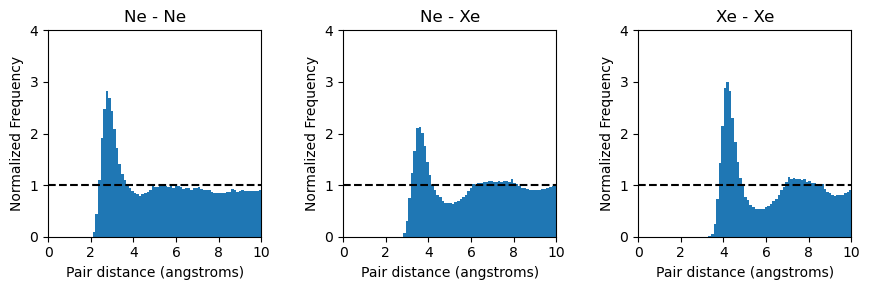

In [18]:
bar_width = histograms[1][1] - histograms[1][0]
pairs = chemical_system.interactions_map[2]
fig, ax = plt.subplots(1, len(pairs), figsize=(len(pairs)*3, 3), dpi=100)
if not isinstance(ax, (list, np.ndarray)):
    ax = [ax]
for i, pair in enumerate(pairs):
    ax[i].bar(histograms[1][:-1],
              histograms[0][pair],
              width=bar_width)
    ax[i].set_title(" - ".join(pair))
    ax[i].plot([0, 10], [1, 1], linestyle="--", color="k")
    ax[i].set_xlim(0, 10)
    ax[i].set_ylim(0, 4)
    ax[i].set_xlabel("Pair distance (angstroms)")
    ax[i].set_ylabel("Normalized Frequency")
fig.tight_layout()

# Compute energy and force features

In [19]:
representation = process.BasisFeaturizer(chemical_system,
                                         bspline_config)

In [20]:
client = ProcessPoolExecutor(max_workers=n_cores)

In [21]:
n_batches = n_cores * 16  # added granularity for more progress bar updates
df_features = representation.evaluate_parallel(df_data,
                                               client,
                                               energy_key=data_coordinator.energy_key,
                                               n_jobs=n_batches)

  0%|          | 0/64 [00:00<?, ?it/s]

In [22]:
df_features.head()

y  n_Ne  n_Xe  ij_0  ij_1  ij_2  ij_3  ij_4  ij_5  ij_6  \
lmp_0 energy -4.426398  32.0  32.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
      fx_0    0.000000   0.0   0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0   
      fx_1   -0.000000   0.0   0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0   
      fx_2   -0.000000   0.0   0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0   
      fx_3    0.000000   0.0   0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0  -0.0   

              ...  ij_74  ij_75     ij_76      ij_77       ij_78     ij_79  \
lmp_0 energy  ...    0.0    0.0  1.761935  77.130036  105.497558  7.610471   
      fx_0    ...   -0.0   -0.0 -0.000000  -0.000000   -0.000000 -0.000000   
      fx_1    ...   -0.0   -0.0 -0.000000  -0.000000   -0.000000 -0.000000   
      fx_2    ...   -0.0   -0.0 -0.000000  -0.000000   -0.000000 -0.000000   
      fx_3    ...   -0.0   -0.0 -0.000000  -0.000000   -0.000000 -0.000000   

              ij_80  ij_81  ij_82  ij_83  
lmp_0 energy    0.0    0.0    0.0    0.0  
      fx_0     -0.0   -0.0   -0.0   -0.0  
      fx_1     -0.0   -0.0   -0.0   -0.0  
      fx_2     -0.0   -0.0   -0.0   -0.0  
      fx_3     -0.0   -0.0   -0.0   -0.0  

[5 rows x 87 columns]

# Fit model

In [23]:
regularizer = bspline_config.get_regularization_matrix(ridge_1b=1e-6,
                                                       curvature_2b=1e-8)

model = least_squares.WeightedLinearModel(bspline_config,
                                          regularizer=regularizer)

Train with 50% of the dataset (200 samples)

In [24]:
training_keys = df_data.index[:n_train]
df_slice = df_features.loc[training_keys]
n_elements = len(chemical_system.element_list)
x_e, y_e, x_f, y_f = least_squares.dataframe_to_tuples(df_slice,
                                                       n_elements=n_elements,
                                                       energy_key="energy")

# Fit with energies and force

In [25]:
model.fit(x_e, y_e, x_f, y_f, weight=0.5)
solutions = least_squares.arrange_coefficients(model.coefficients, 
                                               bspline_config)

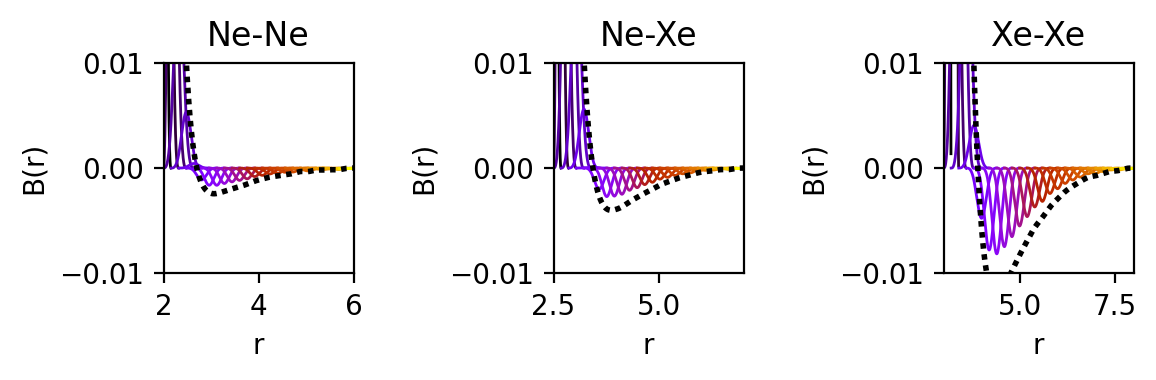

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(6, 2), dpi=200)
for j, interaction in enumerate(bspline_config.interactions_map[2]):
    coefficients = solutions[interaction]
    knot_sequence = bspline_config.knots_map[interaction]
    plotting.visualize_splines(coefficients, 
                               knot_sequence, 
                               ax=axes[j])
    axes[j].set_title("-".join(interaction))
    axes[j].set_ylim(-0.010, 0.010)
fig.tight_layout()


# Prediction

In [27]:
# predict with remainder of dataset
holdout_keys = df_data.index.difference(training_keys)

In [28]:
df_holdout = df_features.loc[holdout_keys]
x_e, y_e, x_f, y_f = least_squares.dataframe_to_tuples(df_holdout,
                                                       n_elements=n_elements,
                                                       energy_key="energy")

In [29]:
p_e = model.predict(x_e)

In [30]:
p_f = model.predict(x_f)

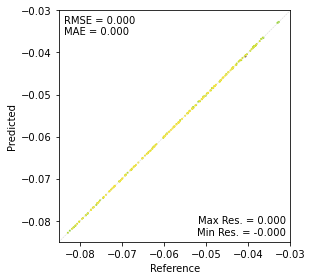

In [31]:
plotting.density_scatter(y_e, p_e)
plt.tight_layout()

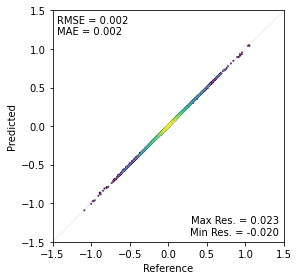

In [32]:
plotting.density_scatter(y_f, p_f)
plt.tight_layout()

In [33]:
solutions = least_squares.arrange_coefficients(model.coefficients, 
                                               bspline_config)

In [34]:
for interaction, values in solutions.items():
    print(interaction, ":", values)

Ne : 0.0
Xe : 0.0
('Ne', 'Ne') : [ 2.15482660e-01  1.71580419e-01  7.70826677e-02  2.71361221e-02
  7.98418278e-03  6.52248637e-04 -1.69617442e-03 -2.45146310e-03
 -2.45346257e-03 -2.19713571e-03 -1.96517184e-03 -1.75920352e-03
 -1.53727874e-03 -1.21318993e-03 -1.03602024e-03 -8.37342116e-04
 -7.52591317e-04 -6.00828957e-04 -5.67021175e-04 -2.49945780e-04
 -4.05262957e-04 -1.34964972e-04 -2.15814133e-04 -1.24220238e-04
 -2.11670800e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
('Ne', 'Xe') : [ 4.85782020e-01  3.95850893e-01  1.93195469e-01  7.70654386e-02
  2.83892035e-02  8.39474359e-03  1.08053948e-04 -3.03352808e-03
 -4.06421323e-03 -3.99440743e-03 -3.72976099e-03 -3.16838707e-03
 -2.79320888e-03 -2.35756807e-03 -2.02670131e-03 -1.57895340e-03
 -1.32587395e-03 -1.05515048e-03 -8.16808761e-04 -6.76830691e-04
 -4.22293657e-04 -3.25803500e-04 -2.77961343e-04 -1.00820993e-04
 -1.96775473e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00]
('Xe', 'Xe') : [ 9.80627089e+01  6.78175

# Export tabulated potentials

In [35]:
model.save("model_pair.json")

In [36]:
table_list = []
pair_list = chemical_system.interactions_map[2]
for pair in pair_list:
    text = lammps.export_tabulated_potential(representation.knots_map[pair],
                                             solutions[pair],
                                             pair,
                                             grid=1000,
                                             filename=None)
    table_list.append(text)
combined_text = "\n\n\n".join(table_list)
table_name = os.path.join(example_directory, "table_test", "Ne_Xe.table")
with open(table_name, "w") as f:
    f.write(combined_text)

# Compute energy, forces, stress with UFCalculator

In [37]:
calc = calculator.UFCalculator(model)

geom = df_data.iloc[200]["geometry"].copy()
geom.set_calculator(calc)
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
print("Max force:", np.max(np.abs(geom.get_forces())))

Energy: [-5.24252979]
Stresses (numerical): [ 1.23694554e-03  1.04022684e-03  1.01873938e-03 -8.13693080e-05
 -1.80044730e-05  4.01856438e-05]
Max force: 0.0132157317068621


# Compare with UFLammps calculator

In [38]:
calc = lammps.UFLammps(lmpcmds=["pair_style table spline 1000",
                                "pair_coeff 1 1 table_test/Ne_Xe.table UF_Ne-Ne 6.0",
                                "pair_coeff 1 2 table_test/Ne_Xe.table UF_Ne-Xe 7.0",
                                "pair_coeff 2 2 table_test/Ne_Xe.table UF_Xe-Xe 8.0"],
                       keep_alive=True)
geom.calc = calc
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
lammps_forces = geom.get_forces()
print("Max force:", np.max(np.abs(lammps_forces)))
del calc

Energy: -5.242526000071701
Stresses (numerical): [ 1.23693843e-03  1.04022236e-03  1.01875533e-03 -8.13630616e-05
 -1.80046436e-05  4.01840615e-05]
Max force: 0.013215293525227772


# Relax with UFLammps calculator

In [39]:
calc = lammps.UFLammps(lmpcmds=["pair_style table spline 1000",
                                "pair_coeff 1 1 table_test/Ne_Xe.table UF_Ne-Ne 6.0",
                                "pair_coeff 1 2 table_test/Ne_Xe.table UF_Ne-Xe 7.0",
                                "pair_coeff 2 2 table_test/Ne_Xe.table UF_Xe-Xe 8.0"],
                       keep_alive=True)
calc.relax(geom)
print("Relaxation Steps:", calc.results["nsteps"])
geom.calc = calc
print("Energy:", geom.get_potential_energy())
print("Stresses (numerical):", geom.get_stress())
lammps_forces = geom.get_forces()
print("Max force:", np.max(np.abs(lammps_forces)))
del calc

Relaxation Steps: 73
Energy: -5.434137194694856
Stresses (numerical): [ 1.35318007e-04 -7.02916555e-05 -5.34327350e-05 -1.58322231e-04
  1.18055814e-05  5.86574641e-05]
Max force: 0.003964100771550409
